# Importing required packages

In [104]:
import pandas as pd
import sys
import math
import numpy as np
import pickle

In [105]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

In [106]:
import sklearn as skl
from sklearn import *

# Loading the 2011 Housing Market Typology dataset and retrieving basic data stats

In [107]:
housingTypologyDF = pd.read_csv('../dat/Housing_Market_Typology_2011.csv')

In [108]:
print('Data Shape (#col x #row) = '+ str(len(housingTypologyDF.columns))+ ' x ' + str(len(housingTypologyDF)))

Data Shape (#col x #row) = 12 x 710


In [109]:
housingTypologyDF.head(10)

,blockGroup,marketCategory,sales20092010,salesPriceCoefficientVariance,commercialResidentialLandRatio,unitsPerSquareMile,residentialPermits,vacantLots,vacantHouseNotices,foreclosureFilings,medianSalesPrice20092010,ownerOccupied
0,101001,Regional Choice,79,0.40,15.25,15225.00,0%,0%,0%,3%,$238000.00,78%
1,101002,Regional Choice,69,0.35,3.59,11975.00,1%,1%,1%,5%,$235000.00,69.4%
2,101003,Regional Choice,47,0.41,5.08,6100.00,0%,3%,0%,3%,$299000.00,78.6%
3,102001,Middle Market Choice,51,0.49,0.00,12300.00,1%,0%,2%,8%,$159900.00,68.8%
4,102002,Regional Choice,32,0.46,0.00,14100.00,0%,0%,2%,5%,$199694.00,77.2%
5,102003,Regional Choice,67,0.32,24577.62,16400.00,0%,0%,0%,3%,$230000.00,77.4%
6,102004,Middle Market Choice,33,0.48,0.00,5016.67,1%,0%,1%,7%,$143250.00,69.2%
7,103001,Regional Choice,54,0.42,12.93,2204.55,0%,3%,1%,4%,$232500.00,76.6%
8,103002,Regional Choice,87,0.46,22.04,22000.00,1%,0%,2%,6%,$189900.00,41.3%
9,104001,Regional Choice,61,0.38,1.61,8383.33,1%,1%,0%,3%,$200000.00,61.5%


In [110]:
# Are block groups unique identifiers?
len(housingTypologyDF)==len(housingTypologyDF.drop_duplicates('blockGroup'))

True

In [111]:
# Drop the 'blockGroup' column as it is a row identifier
housingTypologyDF.drop('blockGroup', axis=1, inplace=True)

In [112]:
housingTypologyDF.dtypes

marketCategory                     object
sales20092010                       int64
salesPriceCoefficientVariance     float64
commercialResidentialLandRatio    float64
unitsPerSquareMile                float64
residentialPermits                 object
vacantLots                         object
vacantHouseNotices                 object
foreclosureFilings                 object
medianSalesPrice20092010           object
ownerOccupied                      object
dtype: object

### Data Cleansing

In [113]:
# Selecting 'marketCategory' as the class label for the dataset. It labels each block per it's demand 
# on the real estate market.
housingTypologyDF['marketCategory']=housingTypologyDF['marketCategory'].astype('category')

# Remove the '%' from values in the columns {residentialPermits, vacantLots, vacantHouseNotices, 
# foreclosureFilings, ownerOccupied} and cast to float datatype.
housingTypologyDF['residentialPermits']=housingTypologyDF['residentialPermits'].replace( '[\%]','', regex=True ).astype(float)
housingTypologyDF['vacantLots']=housingTypologyDF['vacantLots'].replace( '[\%]','', regex=True ).astype(float)
housingTypologyDF['vacantHouseNotices']=housingTypologyDF['vacantHouseNotices'].replace( '[\%]','', regex=True ).astype(float)
housingTypologyDF['foreclosureFilings']=housingTypologyDF['foreclosureFilings'].replace( '[\%]','', regex=True ).astype(float)
housingTypologyDF['ownerOccupied']=housingTypologyDF['ownerOccupied'].replace( '[\%]','', regex=True ).astype(float)

# Remove the dollar symbol from values in the column 'medianSalesPrice20092010' and cast to float datatype
housingTypologyDF['medianSalesPrice20092010']=housingTypologyDF['medianSalesPrice20092010'].replace( '[\$]','', regex=True ).astype(float)

In [114]:
housingTypologyDF.dtypes

marketCategory                    category
sales20092010                        int64
salesPriceCoefficientVariance      float64
commercialResidentialLandRatio     float64
unitsPerSquareMile                 float64
residentialPermits                 float64
vacantLots                         float64
vacantHouseNotices                 float64
foreclosureFilings                 float64
medianSalesPrice20092010           float64
ownerOccupied                      float64
dtype: object

In [115]:
# Check if any column contains missing values
for column in housingTypologyDF.columns:
    print(column + ': ' + str(len(housingTypologyDF)<>len(housingTypologyDF[column].notnull())))

marketCategory: False
sales20092010: False
salesPriceCoefficientVariance : False
commercialResidentialLandRatio: False
unitsPerSquareMile: False
residentialPermits: False
vacantLots: False
vacantHouseNotices: False
foreclosureFilings: False
medianSalesPrice20092010: False
ownerOccupied: False


In [116]:
# Check if any numeric columns contain negative values
for column in housingTypologyDF.columns[1:]:
    print(column + ': ' + str(len(housingTypologyDF.ix[housingTypologyDF[column]<0])>0))

sales20092010: False
salesPriceCoefficientVariance : False
commercialResidentialLandRatio: False
unitsPerSquareMile: False
residentialPermits: False
vacantLots: False
vacantHouseNotices: False
foreclosureFilings: False
medianSalesPrice20092010: False
ownerOccupied: False


# Preliminary Data Analysis

#### Describe numeric features in the data

In [117]:
housingTypologyDF.describe()

,sales20092010,salesPriceCoefficientVariance,commercialResidentialLandRatio,unitsPerSquareMile,residentialPermits,vacantLots,vacantHouseNotices,foreclosureFilings,medianSalesPrice20092010,ownerOccupied
count,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000
mean,18.847887,0.602648,217.150817,5683.015211,0.616901,9.073239,7.405634,5.867606,96691.235211,48.385493
std,14.839127,0.307203,1668.778867,4703.420167,4.037867,12.361286,10.611167,17.069573,99209.184736,22.763382
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.410000,0.327500,2758.455000,0.000000,2.000000,0.000000,3.000000,26062.500000,33.100000
50%,16.000000,0.570000,4.155000,4807.145000,0.000000,5.000000,1.000000,5.000000,62992.500000,48.000000
75%,25.000000,0.807500,15.897500,7510.717500,0.000000,11.000000,12.750000,7.000000,135187.500000,65.400000
max,99.000000,1.760000,30761.430000,71300.000000,100.000000,92.000000,55.000000,450.000000,670000.000000,100.000000


#### Units per square mile should always be non-zero and positive

In [118]:
housingTypologyDF[housingTypologyDF.unitsPerSquareMile==0]

,marketCategory,sales20092010,salesPriceCoefficientVariance,commercialResidentialLandRatio,unitsPerSquareMile,residentialPermits,vacantLots,vacantHouseNotices,foreclosureFilings,medianSalesPrice20092010,ownerOccupied
143,>50 residential lots; >50 % vacant lots,0,0.0,1.60,0.0,0.0,85.0,0.0,0.0,0.0,0.0
145,NR - Non-residential (<50 residential lots),0,0.0,0.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159,< 5 Sales; MultiFamily (>65% of Housing Units),0,0.0,0.00,0.0,0.0,20.0,0.0,0.0,0.0,0.0
329,NR - Non-residential (<50 residential lots),0,0.0,0.00,0.0,0.0,92.0,0.0,0.0,0.0,0.0
493,NR - Non-residential (<50 residential lots),0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
502,NR - Non-residential (<50 residential lots),0,0.0,0.00,0.0,0.0,71.0,0.0,0.0,0.0,0.0
667,NR - Non-residential (<50 residential lots),0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
709,NR - Non-residential (<50 residential lots),0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
# Eliminate the rows we see above. They appear to be incorrect/missing data.
rowIndicesToDelete = housingTypologyDF[housingTypologyDF.unitsPerSquareMile==0].index.get_values().tolist()
housingTypologyDF.drop(rowIndicesToDelete, inplace=True)

#### Making sure median sale price is zero only in case no units were sold in the block

In [120]:
housingTypologyDF[housingTypologyDF.medianSalesPrice20092010==0]

,marketCategory,sales20092010,salesPriceCoefficientVariance,commercialResidentialLandRatio,unitsPerSquareMile,residentialPermits,vacantLots,vacantHouseNotices,foreclosureFilings,medianSalesPrice20092010,ownerOccupied
25,< 5 Sales; MultiFamily (>65% of Housing Units),0,0.0,0.89,3350.00,0.0,6.0,0.0,5.0,0.0,15.7
26,< 5 Sales; MultiFamily (>65% of Housing Units),0,0.0,0.24,9553.33,0.0,12.0,1.0,21.0,0.0,0.1
27,< 5 Sales; MultiFamily (>65% of Housing Units),0,0.0,0.09,483.33,0.0,14.0,1.0,0.0,0.0,4.4
28,< 5 Sales; MultiFamily (>65% of Housing Units),0,0.0,1.73,2390.91,2.0,15.0,0.0,0.0,0.0,0.0
29,< 5 Residential Sales (2009-2010),0,0.0,0.24,6.25,0.0,7.0,0.0,0.0,0.0,0.0
31,NR - Non-residential (<50 residential lots),0,0.0,0.00,4566.67,0.0,3.0,3.0,4.0,0.0,9.4
46,< 5 Sales; MultiFamily (>65% of Housing Units),0,0.0,0.78,7263.64,3.0,17.0,0.0,0.0,0.0,0.0
58,>50 residential lots; >50 % vacant lots,0,0.0,0.00,3075.00,0.0,90.0,0.0,0.0,0.0,0.0
99,>50 residential lots; >50 % vacant lots,0,0.0,0.00,2450.00,22.0,72.0,1.0,2.0,0.0,24.9
144,< 5 Sales; MultiFamily (>65% of Housing Units),0,0.0,208.94,71300.00,100.0,0.0,0.0,0.0,0.0,0.0


#### Compute histogram for blocks per market category

In [121]:
housingTypologyDF.marketCategory.value_counts()

Distressed                                        209
Middle Market Choice                              117
Middle Market Stressed                            114
Regional Choice                                    94
Middle Market                                      92
< 5 Residential Sales (2009-2010)                  30
< 5 Sales; MultiFamily (>65% of Housing Units)     27
>50 residential lots; >40 % vacant lots             8
NR - Non-residential (<50 residential lots)         7
>50 residential lots; >50 % vacant lots             4
Name: marketCategory, dtype: int64

#### Merging the tail end of market categories into a new, single category
The long tail looks like categories for areas where there aren't many sales (hypothesis: either because people dont like those blocks or there aren't many residential properties or residential properties aren't up for sale on the market). Merging all these low count categories into a single category 'Other' should eliminate the long tail.

In [122]:
housingTypologyDF.marketCategory.cat.add_categories('Other', inplace=True)
housingTypologyDF.marketCategory.cat.add_categories('Low Sales', inplace=True)
housingTypologyDF.marketCategory.replace({'< 5 Residential Sales (2009-2010)': 'Other', 
                              '< 5 Sales; MultiFamily (>65% of Housing Units)':'Other',
                             'NR - Non-residential (<50 residential lots)':'Other',
                             '>50 residential lots; >40 % vacant lots':'Other',
                             '>50 residential lots; >50 % vacant lots':'Other'}, inplace=True)
housingTypologyDF = housingTypologyDF[housingTypologyDF.marketCategory!='Other']
housingTypologyDF.marketCategory.cat.remove_unused_categories(inplace=True)

housingTypologyDF.marketCategory.value_counts()

Distressed                209
Middle Market Choice      117
Middle Market Stressed    114
Regional Choice            94
Middle Market              92
Name: marketCategory, dtype: int64

#### Compute the correlation matrix for numeric features

In [123]:
housingTypologyDF.corr(method='pearson')

,sales20092010,salesPriceCoefficientVariance,commercialResidentialLandRatio,unitsPerSquareMile,residentialPermits,vacantLots,vacantHouseNotices,foreclosureFilings,medianSalesPrice20092010,ownerOccupied
sales20092010,1.000000,-0.142799,0.094264,0.313487,0.001093,-0.258139,-0.176083,0.075347,0.173144,0.220415
salesPriceCoefficientVariance,-0.142799,1.000000,-0.025556,0.019180,0.036148,0.335922,0.642672,0.250703,-0.569253,-0.436396
commercialResidentialLandRatio,0.094264,-0.025556,1.000000,0.098091,-0.021662,-0.027280,0.002470,-0.037405,0.007333,0.061816
unitsPerSquareMile,0.313487,0.019180,0.098091,1.000000,0.105700,-0.228818,0.023829,0.027270,0.017630,-0.283690
residentialPermits,0.001093,0.036148,-0.021662,0.105700,1.000000,0.177227,0.072779,-0.117744,0.178610,-0.178138
vacantLots,-0.258139,0.335922,-0.027280,-0.228818,0.177227,1.000000,0.430758,-0.018643,-0.232977,-0.362881
vacantHouseNotices,-0.176083,0.642672,0.002470,0.023829,0.072779,0.430758,1.000000,0.055096,-0.510731,-0.509959
foreclosureFilings,0.075347,0.250703,-0.037405,0.027270,-0.117744,-0.018643,0.055096,1.000000,-0.400000,-0.152669
medianSalesPrice20092010,0.173144,-0.569253,0.007333,0.017630,0.178610,-0.232977,-0.510731,-0.400000,1.000000,0.323228
ownerOccupied,0.220415,-0.436396,0.061816,-0.283690,-0.178138,-0.362881,-0.509959,-0.152669,0.323228,1.000000


#### Conduct Principal Component Analysis (PCA) on the dataset

In [124]:
scaledDf = housingTypologyDF.drop('marketCategory', axis=1)
scaledDf = skl.preprocessing.scale(scaledDf)
pca=skl.decomposition.PCA(n_components=10, whiten=True)
pca.fit(scaledDf)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [125]:
pca.components_

array([[-0.20399405,  0.47419637, -0.03921834, -0.00412604,  0.04582208,
         0.34598521,  0.47804114,  0.18118131, -0.42556265, -0.40952428],
       [ 0.51488113,  0.11186875,  0.19065983,  0.59520969, -0.11433469,
        -0.36348006,  0.0033743 ,  0.37607421, -0.17829713, -0.11547217],
       [ 0.10514412, -0.04804547,  0.08160751,  0.40773173,  0.62881855,
         0.16347026,  0.10922064, -0.4038409 ,  0.34086175, -0.31684815],
       [ 0.00537334,  0.04171097,  0.91438122, -0.09129096, -0.17315533,
         0.12237636,  0.14230278, -0.2523496 , -0.05021985,  0.14964323],
       [ 0.36955634,  0.0540445 ,  0.14238794, -0.36471292,  0.54942831,
         0.28148736, -0.11702662,  0.50215179,  0.00771949,  0.24535611],
       [-0.62916202, -0.23462873,  0.30179231,  0.11386451,  0.18777902,
        -0.14512221, -0.3340888 ,  0.43088922,  0.01240549, -0.30216654],
       [ 0.2222451 , -0.3479777 , -0.01043152,  0.08762517, -0.43149244,
         0.65745372, -0.16223598,  0.16493152

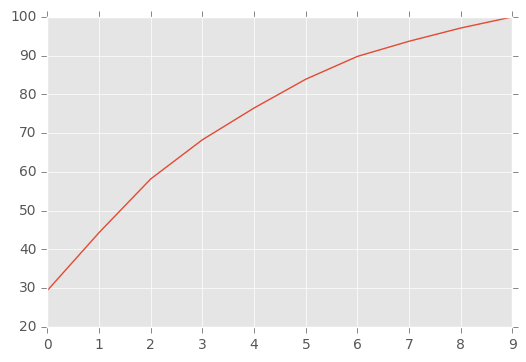

In [126]:
cumulativeVariance = pca.explained_variance_ratio_.cumsum()
# print(cumulativeVariance)
matplotlib.pyplot.plot(cumulativeVariance * 100)

#### Autocorrelation analysis by sorting on certain numeric features (EXPERIMENTAL)

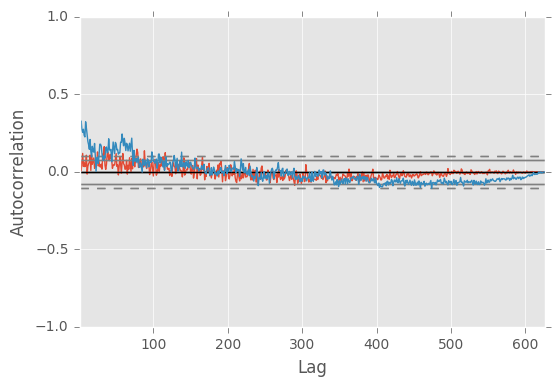

In [127]:
from pandas.tools.plotting import autocorrelation_plot
# autocorrelation_plot(housingTypologyDF.sort_values(by='unitsPerSquareMile').medianSalesPrice20092010)
# autocorrelation_plot(housingTypologyDF.sort_values(by='marketCategory').medianSalesPrice20092010)
autocorrelation_plot(housingTypologyDF.sort_values(by='vacantLots').medianSalesPrice20092010)
autocorrelation_plot(housingTypologyDF.sort_values(by='foreclosureFilings').medianSalesPrice20092010)
# autocorrelation_plot(housingTypologyDF.sort_values(by='sales20092010').medianSalesPrice20092010)

## Training a decision tree classifier

In [128]:
housingTypologyDF = housingTypologyDF.reindex(np.random.permutation(housingTypologyDF.index))

X=housingTypologyDF.copy()
X.drop(['marketCategory'], axis=1, inplace=True)
X = pd.DataFrame(skl.preprocessing.scale(X), index=X.index, columns=X.columns)

le = preprocessing.LabelEncoder()
Y = le.fit_transform(housingTypologyDF['marketCategory'])
encodeValues = sorted(pd.unique(Y).tolist())
print(encodeValues)
le.inverse_transform(encodeValues)

[0, 1, 2, 3, 4]


array(['Distressed', 'Middle Market', 'Middle Market Choice',
       'Middle Market Stressed', 'Regional Choice'], dtype=object)

In [129]:
labelMap = {
    'Low Sales':0,
    'Distressed':1, 
    'Middle Market Stressed':2, 
    'Middle Market':3, 
    'Middle Market Choice':4,
    'Regional Choice':5}

Y=housingTypologyDF['marketCategory']
Y=Y.astype(str)
for label, val in labelMap.iteritems():
    Y[Y==label]=val
Y=Y.astype(int)

In [130]:
dt = skl.tree.DecisionTreeClassifier()
dt.fit(X.values, Y)

with open("../out/dt.dot", 'w') as f:
    skl.tree.export_graphviz(dt, out_file=f, feature_names=X.columns)
    
scores = skl.cross_validation.cross_val_score(dt, X, Y, cv = 50)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.96 (+/- 0.12)


In [131]:
dt.feature_importances_

array([ 0.01429872,  0.00308668,  0.        ,  0.01300937,  0.00308668,
        0.00718355,  0.02018455,  0.        ,  0.92966174,  0.00948869])

In [132]:
skl.metrics.confusion_matrix(Y, dt.predict(X))

array([[209,   0,   0,   0,   0],
       [  0, 114,   0,   0,   0],
       [  0,   0,  92,   0,   0],
       [  0,   0,   0, 117,   0],
       [  0,   0,   0,   0,  94]])

In [133]:
X.columns

Index([u'sales20092010', u'salesPriceCoefficientVariance ',
       u'commercialResidentialLandRatio', u'unitsPerSquareMile',
       u'residentialPermits', u'vacantLots', u'vacantHouseNotices',
       u'foreclosureFilings', u'medianSalesPrice20092010', u'ownerOccupied'],
      dtype='object')

### Training Decision Tree Classifier w/ Modified Best Predictors

In [134]:
unitsPerSale = housingTypologyDF.unitsPerSquareMile.divide(housingTypologyDF.sales20092010)
unitsPerSale[pd.isnull(unitsPerSale)]=-1
unitsPerSale[unitsPerSale==np.Inf]=-1
unitsPerSale=pd.DataFrame(unitsPerSale)

In [135]:
scaler = skl.preprocessing.MinMaxScaler(feature_range=(0,10))
scaledUnitsPerSale = scaler.fit_transform(unitsPerSale.values.reshape(-1,1))
scaledUnitsPerSale=pd.DataFrame(scaledUnitsPerSale, 
                              index = unitsPerSale.index)
scaledSalesPrice = scaler.fit_transform(housingTypologyDF.medianSalesPrice20092010.values.reshape(-1,1))
scaledSalesPrice=pd.DataFrame(scaledSalesPrice, 
                              index = housingTypologyDF.medianSalesPrice20092010.index)

# scaledVacantLots = scaler.fit_transform(housingTypologyDF.vacantLots.values.reshape(-1,1))
# scaledVacantLots = pd.DataFrame(scaledVacantLots, 
#                                index=housingTypologyDF.vacantLots.index)

scaledVacantHouseNotices = scaler.fit_transform(housingTypologyDF.vacantHouseNotices.values.reshape(-1,1))
scaledVacantHouseNotices = pd.DataFrame(scaledVacantHouseNotices, 
                               index=housingTypologyDF.vacantHouseNotices.index)

In [136]:
# X_prime = pd.concat([unitsPerSale, housingTypologyDF.medianSalesPrice20092010 ], axis=1)
X_prime = pd.concat([scaledUnitsPerSale, scaledSalesPrice], axis=1)
X_prime.columns = ['unitsPerSale', 'medianSalesPrice']
# X_prime = pd.concat([scaledUnitsPerSale, scaledSalesPrice, scaledVacantHouseNotices], axis=1)
# X_prime.columns = ['unitsPerSale', 'medianSalesPrice', 'vacantHouseNotices']
X_prime.unitsPerSale.replace(np.Inf, np.nan, inplace=True)
X_prime.unitsPerSale.fillna(value='-1', inplace=True)

X_prime.medianSalesPrice.replace(np.Inf, np.nan, inplace=True)
X_prime.medianSalesPrice.fillna(value='-1', inplace=True)

In [137]:
X_prime.head()

,unitsPerSale,medianSalesPrice
216,1.562157,0.222638
247,0.544988,0.170006
525,0.579497,2.139753
540,0.667492,1.542582
105,2.788096,0.629346


In [138]:
dt_prime = skl.tree.DecisionTreeClassifier()
dt_prime.fit(X_prime.values, Y)

with open("dt.dot", 'w') as f:
    skl.tree.export_graphviz(dt_prime, out_file=f, feature_names=X_prime.columns)
    
scores = skl.cross_validation.cross_val_score(dt_prime, X_prime, Y, cv = 10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.94 (+/- 0.05)


In [139]:
skl.metrics.confusion_matrix(Y, dt_prime.predict(X_prime))

array([[209,   0,   0,   0,   0],
       [  0, 114,   0,   0,   0],
       [  0,   0,  92,   0,   0],
       [  0,   0,   0, 117,   0],
       [  0,   0,   0,   0,  94]])

In [39]:
pickle.dump(dt_prime, open('../models/housing_market_typology_decisionTree.model','wb'))

In [40]:
pd.DataFrame(Y).marketCategory.value_counts()

1    209
4    117
2    114
5     94
3     92
Name: marketCategory, dtype: int64

In [41]:
dt_prime.feature_importances_

array([ 0.03918314,  0.96081686])

In [42]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_prime.values, Y)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [102]:
def displayCorrelationMatrix(corrMtx, figSize=(8,8)):
    corrMtx=np.absolute(corrMtx)
    mask =  np.tri(corrMtx.shape[0], k=-1)
    masked = np.ma.array(corrMtx, mask=mask)

    fig = matplotlib.pyplot.figure(figsize=figSize, dpi=80)
    ax = fig.add_subplot(111)
    cmap = matplotlib.cm.get_cmap(name='gray_r')
    cmap.set_bad('w')
    cax=ax.imshow(masked.transpose(), interpolation="nearest", cmap=cmap)

    
    fig.colorbar(cax, shrink=.6, aspect=20)
#     fig.colorbar(cax)

    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    ax.set_xticks(np.arange(len(corrMtx.columns)))
    ax.set_yticks(np.arange(len(corrMtx.columns)))
    ax.set_xticklabels(corrMtx.columns, rotation=90)
    ax.set_yticklabels(corrMtx.columns)
#     matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig('../doc/Project Report/vacant_house_notices_corr.png')

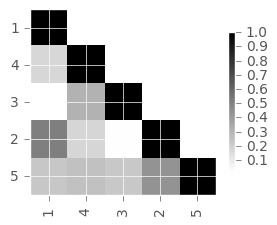

In [103]:
dfExcerpt = housingTypologyDF.loc[:,['medianSalesPrice20092010','sales20092010','unitsPerSquareMile', 'vacantHouseNotices', 'vacantLots']]
# dfExcerpt = pd.DataFrame(skl.preprocessing.scale(dfExcerpt), index=dfExcerpt.index, columns=dfExcerpt.columns)
dfExcerpt = pd.DataFrame(skl.preprocessing.scale(dfExcerpt), index=dfExcerpt.index, columns=['1','4','3','2', '5'])
displayCorrelationMatrix(dfExcerpt.corr(method='pearson'), figSize=(3,3))